In [9]:
# !pip install -q sentence-transformers chromadb gdown matplotlib pillow numpy

In [1]:
import os
from glob import glob
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import chromadb
import matplotlib.pyplot as plt

In [2]:
# Load pretrained ResNet50 and remove final classification layer
resnet_model = models.resnet50(pretrained=True)
resnet_model = torch.nn.Sequential(*list(resnet_model.children())[:-1])  # Remove last FC layer
resnet_model.eval()

c:\Users\ravin\anaconda3\envs\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ravin\anaconda3\envs\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [3]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Function to generate pattern-based embedding
def get_pattern_embedding(img_path, model):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)  # Batch dimension
    with torch.no_grad():
        features = model(img_tensor).squeeze().numpy()  # Extract features and convert to numpy
    return features.flatten()  # Shape: (2048,)

image_folder = 'image_dataset'
image_paths = glob(os.path.join(image_folder, '*.jpg'))

# Generate embeddings for all images
embedding_list = [get_pattern_embedding(img_path, resnet_model).tolist() for img_path in image_paths]

In [5]:
# Initialize ChromaDB client and collection
chroma_client = chromadb.PersistentClient(path='./vectordb')
collection = chroma_client.get_or_create_collection(name='image_collection')

# Add embeddings to ChromaDB
collection.add(
    documents=image_paths,
    embeddings=embedding_list,
    ids=[str(i) for i in range(len(embedding_list))]
)

print("✅ Embeddings stored in ChromaDB and persisted.")

Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 3
Add of existing embedding ID: 4
Add of existing embedding ID: 5
Add of existing embedding ID: 6
Add of existing embedding ID: 7
Add of existing embedding ID: 8
Add of existing embedding ID: 9
Add of existing embedding ID: 10
Add of existing embedding ID: 11
Add of existing embedding ID: 12
Add of existing embedding ID: 13
Add of existing embedding ID: 14
Add of existing embedding ID: 15
Add of existing embedding ID: 16
Add of existing embedding ID: 17
Add of existing embedding ID: 18
Add of existing embedding ID: 19
Add of existing embedding ID: 20
Add of existing embedding ID: 21
Add of existing embedding ID: 22
Add of existing embedding ID: 23
Add of existing embedding ID: 24
Add of existing embedding ID: 25
Add of existing embedding ID: 26
Add of existing embedding ID: 27
Add of existing embedding ID: 28
Add of existing embedding ID: 29
Add of existing embe

✅ Embeddings stored in ChromaDB and persisted.


In [6]:
# Function to load collection (later use)
def load_chroma_collection(path='./vectordb', name='image_collection'):
    chroma_client = chromadb.PersistentClient(path=path)
    collection = chroma_client.get_or_create_collection(name=name)
    print(f"✅ Loaded ChromaDB collection '{name}'")
    return collection
collection = load_chroma_collection()  # Load existing collection

# Function to query similar images
def retrieve_similar_images(query_image_path, model, collection, top_k=3):
    # Generate embedding for query image
    query_embedding = get_pattern_embedding(query_image_path, model)
    
    # Query ChromaDB
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k
    )
    # Retrieved image paths
    retrieved_image_paths = results['documents'][0]
    return retrieved_image_paths

✅ Loaded ChromaDB collection 'image_collection'


In [7]:
def visualize_results(query_image_path, retrieved_image_paths):
    plt.figure(figsize=(15, 5))

    # Display query image
    plt.subplot(1, len(retrieved_image_paths) + 1, 1)
    plt.imshow(Image.open(query_image_path))
    plt.title("Query Image")
    plt.axis('off')

    # Display retrieved images
    for i, img_path in enumerate(retrieved_image_paths):
        plt.subplot(1, len(retrieved_image_paths) + 1, i + 2)
        plt.imshow(Image.open(img_path))
        plt.title(f"Match {i + 1}")
        plt.axis('off')

    plt.show()

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\ravin\AppData\Local\Temp\ipykernel_37616\312037330.py:1: SyntaxWarning: invalid escape sequence '\p'
  query_image = 'image_dataset\pexels-andrew-3201768.jpg'


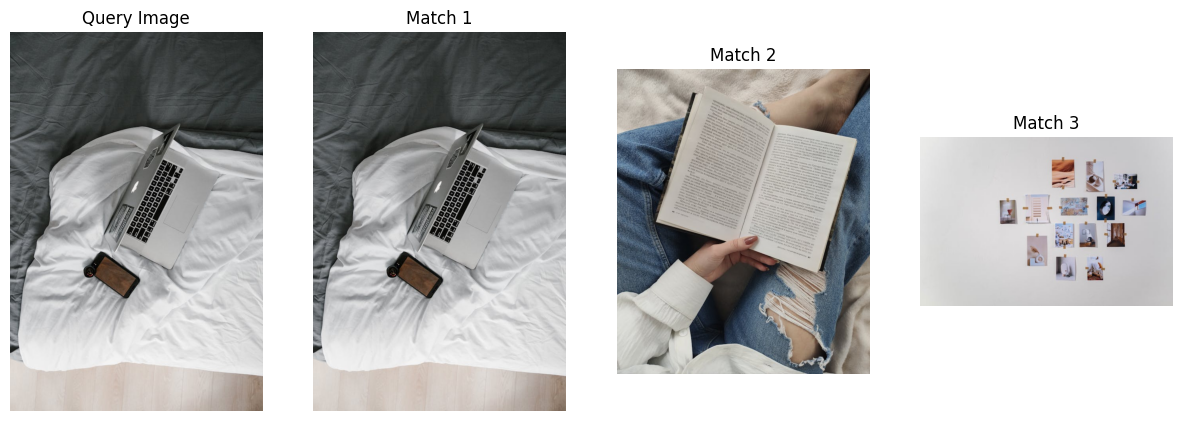

In [8]:
query_image = 'image_dataset\pexels-andrew-3201768.jpg'

retrieved_images = retrieve_similar_images(query_image, resnet_model, collection, top_k=3)
visualize_results(query_image, retrieved_images)